In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve

- Submission_1 : Single XGB with random state 0 with SMOTE
- Submission_2 : Combination of 5 XGB and 5 Random Forest with Random state 0 with SMOTE
- Submission_3 : Combination of 5 Random Forest with Random state 0 with SMOTE
- Submission_4 : Submission 3 with Annual Income Dropped
- Submission_5 : Submission 2 with Annual Income Dropped
- Submission_6 : Submission 3 with Annual Income, Stay Duration of Current Residence and Tenure of Oldest Credit Line Dropped and random states 10 everywhere
- Submission_7 : Stacked Classifier with XGB, RF and SVM as base and CAT as Stack with features as Submission_6
- Submission_8 : RF with Randomsearch 1000 iters best results features same as submission 6
- Submission_9 : Manually tuned RF with same features as sub 6
- Submission_10 : RF with class weights and oob scores, removed SMOTE, rest same as S9
- Submission_11 : S10 with all features and 130 estimators

In [3]:
train = pd.read_csv('TrainingData.csv')
test = pd.read_csv('testX.csv')

df = pd.concat([train, test], axis = 0)

df.shape

/tmp/ipykernel_18414/1837120322.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('TrainingData.csv')
/tmp/ipykernel_18414/1837120322.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('testX.csv')


(130000, 53)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 46999
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   application_key  130000 non-null  int64  
 1   mvar1            130000 non-null  object 
 2   mvar2            120787 non-null  float64
 3   mvar3            129171 non-null  float64
 4   mvar4            129171 non-null  float64
 5   mvar5            129171 non-null  float64
 6   mvar6            130000 non-null  object 
 7   mvar7            130000 non-null  object 
 8   mvar8            130000 non-null  object 
 9   mvar9            130000 non-null  object 
 10  mvar10           130000 non-null  object 
 11  mvar11           130000 non-null  object 
 12  mvar12           130000 non-null  object 
 13  mvar13           130000 non-null  object 
 14  mvar14           130000 non-null  int64  
 15  mvar15           130000 non-null  object 
 16  mvar16           130000 non-null  objec

In [5]:
columns = ['ID',
           'Credit Worthiness Score',
           'Number and Riskiness of Credit Enquiry',
           'Default Severity (Any Loan)',
           'Default Severity (Auto Loan)',
           'Default Severity (Education Loan)',
           'Min Cred Available (Revolving Credit Cards)',
           'Max Cred Available (Active Credit Lines)',
           'Max Cred Available (Active Revolving Credit Cards)',
           'Total Available Credit (Cards with 1 missed payment)',
           'Total Credit Available',
           'Dues Collected Post Default',
           'Total Amount Due (Active Cards)',
           'Credit Amount Paid (Prev Year)',
           'Annual Income',
           'Property Value',
           'Full Credit Utilisation (Revolving Credit Cards)',
           'Full Credit Utilisation (Credit Cards)',
           'Full Credit Utilisation (Credit Lines)',
           '>75 percent Credit Utilisation (Credit Cards)',
           '>75 percent Credit Utilisation (Credit Lines)',
           'Average Utilisation (Revolving Credit Cards)',
           'Average Utilisation Last 2 Years (All Credit Lines)',
           'Average Utilisation Last Year (All Credit Cards)',
           'Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards)',
           'Average Tenure (Active Revolving Credit Cards)',
           'Tenure of Oldest Active Credit Card',
           'Tenure of Oldest Active Revolving Credit Card',
           'Days Since Last Missed Payment',
           'Tenure of Oldest Credit Line',
           'Max Tenure (Auto Loans)',
           'Max Tenure (Education Loans)',
           'Sum of Tenures (Active Credit Cards)',
           'Stay Duration of Current Residence',
           'Credit Lines with 1 Missed Payment (Last 6 Months)',
           'Revolving Credit Cards with 1 Missed Payment (Last 2 Years)',
           'Active Credit Lines',
           'Credit Cards with >2Y Tenure',
           'Credit Lines activated Prev 2 Years',
           'Credit Lines with Current Delinquency',
           'Utilization on Active Education Loans',
           'Utilization on Active Auto Loans',
           'Financial Stress Index',
           'Credit Lines with No Missed Payments (Prev 2 Years)',
           'Ratio(Max Amount Due : Sum of Amounts Due)',
           'Mortgage Loans (With 2 Missed Payements)',
           'Auto Loans (With 2 Missed Payments)',
           'Type of Product',
           'Int Value for an Application',
           'Bucketized Credit Worthiness Score',
           'Compound of mvar49 and mvar48',
           'mvar51',
           'default_ind']

In [6]:
df.columns = columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 46999
Data columns (total 53 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   ID                                                                      130000 non-null  int64  
 1   Credit Worthiness Score                                                 130000 non-null  object 
 2   Number and Riskiness of Credit Enquiry                                  120787 non-null  float64
 3   Default Severity (Any Loan)                                             129171 non-null  float64
 4   Default Severity (Auto Loan)                                            129171 non-null  float64
 5   Default Severity (Education Loan)                                       129171 non-null  float64
 6   Min Cred Available (Revolving Credit Cards)                          

### Feature Understanding (Explanations and Stuff to Look into)

- Auto Loans: Loans where Vehicles are kept as collateral
- Revolving Credit: You have a fixed amount that you can borrow in some fixed time frame. After that the amount you can borrow replenishes to the full amount. Although you will have a maximum limit. For example, you can borrow 100 rupees a month max and the overall limit on that credit line is 500 rupees. So if your overall borrowed amount is 460 rupees and for that month you havenn't borrowed anything so far, you will be able to borrow only 40 rupees even though the monthly limit is 100
- Difference between Credit Worthiness Score and its bucketized version?
- Difference in statistics between train and test (Need for Adverserial Validation?)

### Feature Ideas and Experiments
- Binary Variable for checking if the person has moved into current residence after issuing any credit lines
- Credit Amount Paid / Number of Credit Lines with No Missed Payments
- Max Cred Available vs Default Severity
- Separate modeling for 0 Default Severity vs Non-Zero Default Severity
- KNN Missing Values Fill In
- Property Value vs Annual Income (Some Indicator of whether or not a person spends too much for their Income)
- 75% utilisation / Full Utilisation

In [8]:
df.head(10)

,ID,Credit Worthiness Score,Number and Riskiness of Credit Enquiry,Default Severity (Any Loan),Default Severity (Auto Loan),Default Severity (Education Loan),Min Cred Available (Revolving Credit Cards),Max Cred Available (Active Credit Lines),Max Cred Available (Active Revolving Credit Cards),Total Available Credit (Cards with 1 missed payment),Total Credit Available,Dues Collected Post Default,Total Amount Due (Active Cards),Credit Amount Paid (Prev Year),Annual Income,Property Value,Full Credit Utilisation (Revolving Credit Cards),Full Credit Utilisation (Credit Cards),Full Credit Utilisation (Credit Lines),>75 percent Credit Utilisation (Credit Cards),>75 percent Credit Utilisation (Credit Lines),Average Utilisation (Revolving Credit Cards),Average Utilisation Last 2 Years (All Credit Lines),Average Utilisation Last Year (All Credit Cards),Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards),Average Tenure (Active Revolving Credit Cards),Tenure of Oldest Active Credit Card,Tenure of Oldest Active Revolving Credit Card,Days Since Last Missed Payment,Tenure of Oldest Credit Line,Max Tenure (Auto Loans),Max Tenure (Education Loans),Sum of Tenures (Active Credit Cards),Stay Duration of Current Residence,Credit Lines with 1 Missed Payment (Last 6 Months),Revolving Credit Cards with 1 Missed Payment (Last 2 Years),Active Credit Lines,Credit Cards with >2Y Tenure,Credit Lines activated Prev 2 Years,Credit Lines with Current Delinquency,Utilization on Active Education Loans,Utilization on Active Auto Loans,Financial Stress Index,Credit Lines with No Missed Payments (Prev 2 Years),Ratio(Max Amount Due : Sum of Amounts Due),Mortgage Loans (With 2 Missed Payements),Auto Loans (With 2 Missed Payments),Type of Product,Int Value for an Application,Bucketized Credit Worthiness Score,Compound of mvar49 and mvar48,mvar51,default_ind
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,missing,6423,3067,123875,missing,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,na,0,C,10,770,4,3080,0.0
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,missing,765,1931,42613,missing,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,missing,2251,169,0.4167,0,0,8,0,2,0,99.129,missing,0,13,0.63836,na,na,L,732,437,5,2185,1.0
2,230034,1745,0.4001,0.000,0.0,0.0,missing,2536,missing,missing,2536,missing,missing,missing,76109,missing,na,na,na,0,0,NaN,NaN,NaN,NaN,missing,missing,missing,669,4623,3772,missing,missing,25.0833,0,na,1,na,1,0,missing,29.29,0,1,1.00000,na,0,C,89,795,4,3180,1.0
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,missing,0,0,84235,missing,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,missing,3741,215,10.3333,0,0,3,3,2,0,96.272,missing,0.15385,3,0.53241,0,0,L,3,755,4,3020,0.0
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,missing,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,missing,1947,158,0.9167,0,0,2,3,2,0,115.019,missing,0,1,0.92665,na,na,L,5,425,4,1700,0.0
5,230037,1579,NaN,3.502,0.0,0.0,missing,missing,missing,missing,0,199,missing,missing,77298,missing,na,na,na,0,0,NaN,NaN,NaN,NaN,missing,missing,missing,183,973,missing,missing,missing,1.3333,0,na,2,na,2,na,missing,missing,1.5,0,NaN,na,na,C,35,455,4,1820,1.0
6,230038,1818,0.4001,0.000,0.0,0.0,missing,1088,missing,1536,1498,missing,448,2331,123875,missing,na,0,0,0,0,NaN,NaN,NaN,29.16,1034,760,missing,30386,3437,missing,791,34,9.3333,0,na,2,0,0,0,88.171,missing,0,2,0.87224,na,0,C,2,392,5,1960,1.0
7,230039,na,NaN,NaN,NaN,NaN,missing,missing,missing,missing,missing,missing,missing,missing,198200,1263525,na,na,na,0,na,NaN,NaN,NaN,NaN,missing,missing,missing,missing,missing,missing,missing,missing,0.0833,na,na,na,na,na,na,missing,missing,missing,na,NaN,na,na,C,2,615,#VALUE!,#VALUE!,0.0
8,230040,1836,0.1358,0.000,0.0,0.0,347,38964,17828,70729,65843,missing,16298,18877,109010,missing,0,0,0,1,1,32.02,0.00,0.00,

In [9]:
df.replace('missing', np.nan, inplace = True)
df.replace('na', np.nan, inplace = True)
df.replace('#VALUE!', np.nan, inplace = True)

In [10]:
df.head(10)

,ID,Credit Worthiness Score,Number and Riskiness of Credit Enquiry,Default Severity (Any Loan),Default Severity (Auto Loan),Default Severity (Education Loan),Min Cred Available (Revolving Credit Cards),Max Cred Available (Active Credit Lines),Max Cred Available (Active Revolving Credit Cards),Total Available Credit (Cards with 1 missed payment),Total Credit Available,Dues Collected Post Default,Total Amount Due (Active Cards),Credit Amount Paid (Prev Year),Annual Income,Property Value,Full Credit Utilisation (Revolving Credit Cards),Full Credit Utilisation (Credit Cards),Full Credit Utilisation (Credit Lines),>75 percent Credit Utilisation (Credit Cards),>75 percent Credit Utilisation (Credit Lines),Average Utilisation (Revolving Credit Cards),Average Utilisation Last 2 Years (All Credit Lines),Average Utilisation Last Year (All Credit Cards),Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards),Average Tenure (Active Revolving Credit Cards),Tenure of Oldest Active Credit Card,Tenure of Oldest Active Revolving Credit Card,Days Since Last Missed Payment,Tenure of Oldest Credit Line,Max Tenure (Auto Loans),Max Tenure (Education Loans),Sum of Tenures (Active Credit Cards),Stay Duration of Current Residence,Credit Lines with 1 Missed Payment (Last 6 Months),Revolving Credit Cards with 1 Missed Payment (Last 2 Years),Active Credit Lines,Credit Cards with >2Y Tenure,Credit Lines activated Prev 2 Years,Credit Lines with Current Delinquency,Utilization on Active Education Loans,Utilization on Active Auto Loans,Financial Stress Index,Credit Lines with No Missed Payments (Prev 2 Years),Ratio(Max Amount Due : Sum of Amounts Due),Mortgage Loans (With 2 Missed Payements),Auto Loans (With 2 Missed Payments),Type of Product,Int Value for an Application,Bucketized Credit Worthiness Score,Compound of mvar49 and mvar48,mvar51,default_ind
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,NaN,6423,3067,123875,NaN,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,NaN,0,C,10,770,4,3080,0.0
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,NaN,765,1931,42613,NaN,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,NaN,2251,169,0.4167,0,0,8,0,2,0,99.129,NaN,0,13,0.63836,NaN,NaN,L,732,437,5,2185,1.0
2,230034,1745,0.4001,0.000,0.0,0.0,NaN,2536,NaN,NaN,2536,NaN,NaN,NaN,76109,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,669,4623,3772,NaN,NaN,25.0833,0,NaN,1,NaN,1,0,NaN,29.29,0,1,1.00000,NaN,0,C,89,795,4,3180,1.0
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,NaN,0,0,84235,NaN,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,NaN,3741,215,10.3333,0,0,3,3,2,0,96.272,NaN,0.15385,3,0.53241,0,0,L,3,755,4,3020,0.0
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,NaN,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,NaN,1947,158,0.9167,0,0,2,3,2,0,115.019,NaN,0,1,0.92665,NaN,NaN,L,5,425,4,1700,0.0
5,230037,1579,NaN,3.502,0.0,0.0,NaN,NaN,NaN,NaN,0,199,NaN,NaN,77298,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183,973,NaN,NaN,NaN,1.3333,0,NaN,2,NaN,2,NaN,NaN,NaN,1.5,0,NaN,NaN,NaN,C,35,455,4,1820,1.0
6,230038,1818,0.4001,0.000,0.0,0.0,NaN,1088,NaN,1536,1498,NaN,448,2331,123875,NaN,NaN,0,0,0,0,NaN,NaN,NaN,29.16,1034,760,NaN,30386,3437,NaN,791,34,9.3333,0,NaN,2,0,0,0,88.171,NaN,0,2,0.87224,NaN,0,C,2,392,5,1960,1.0
7,230039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198200,1263525,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,2,615,NaN,NaN,0.0
8,230040,1836,0.1358,0.000,0.0,0.0,347,38964,17828,70729,65843,NaN,16298,18877,109010,NaN,0,0,0,1,1,32.02,0.00,0.00,32.92,3180,8943,8943,1490,12075,NaN,NaN,1673,5.9167,0,NaN,6,12,2,0,NaN,NaN,0,10,0.89868,0,0,L,5,821,5,4105,1.0
9,230041,1839,0.1981,0.000,0.0,0.0,793,6131,6045,48959,31640,NaN,10565,14282,99100,146668,0,0,0,1,1,46.17,NaN,NaN,49.07,1701,8912,2707,61

In [11]:
df.reset_index(drop = True, inplace = True)

In [12]:
df.fillna(-1, inplace = True)

In [13]:
def convert_to_int(entry):
    return float(entry)

for col in df.columns:
    if col != 'Type of Product':
        df[col] = df[col].apply(convert_to_int)
    
df['Credit Worthiness Score'][0]

1696.0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 53 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   ID                                                                      130000 non-null  float64
 1   Credit Worthiness Score                                                 130000 non-null  float64
 2   Number and Riskiness of Credit Enquiry                                  130000 non-null  float64
 3   Default Severity (Any Loan)                                             130000 non-null  float64
 4   Default Severity (Auto Loan)                                            130000 non-null  float64
 5   Default Severity (Education Loan)                                       130000 non-null  float64
 6   Min Cred Available (Revolving Credit Cards)                         

In [15]:
df['default_ind'].value_counts()

 0.0    59145
-1.0    47000
 1.0    23855
Name: default_ind, dtype: int64

In [16]:
le = LabelEncoder()
df['Type of Product'] = le.fit_transform(df['Type of Product'])

In [17]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
df['NumberandRiskinessofCreditEnquiry']

### Adverserial Model (RF)

In [46]:
drop_cols = ['ID', 'default_ind']
train = df.iloc[:83000, :].drop(drop_cols, axis = 1)
test = df.iloc[83000:, :].drop(drop_cols, axis = 1)

train['dataset_label'] = 0
test['dataset_label'] = 1

adf = pd.concat([train, test], axis = 0)

x = adf.drop(['dataset_label'], axis = 1)
y = adf['dataset_label']

xt, xv, yt, yv = train_test_split(x, y, test_size=0.15, random_state=0, stratify = y)

rf = RandomForestClassifier(n_estimators = 100, max_depth=8, oob_score = True,
                                class_weight = 'balanced_subsample', n_jobs=-1,
                                random_state=10)
rf.fit(xt, yt)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       n_jobs=-1, oob_score=True, random_state=10)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


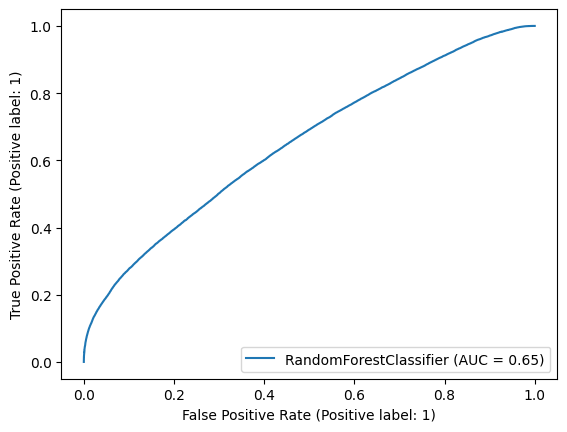

In [47]:
plot_roc_curve(rf, xt, yt)

Text(0.5, 1.0, 'Feature Importance')

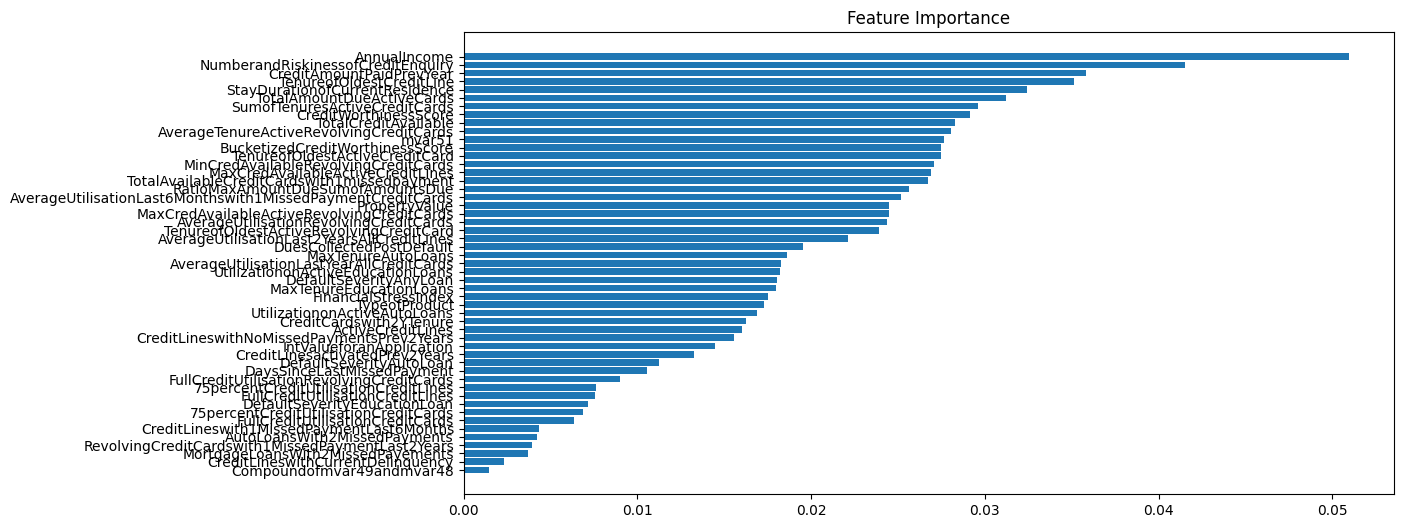

In [48]:
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title('Feature Importance')

### Final Training

In [58]:
train = df.iloc[:83000, :]

X_data = train.drop(['ID', 'default_ind', 'StayDurationofCurrentResidence', 'AnnualIncome', 'TenureofOldestCreditLine'], axis = 1)
y_data = train['default_ind']

X_data, X_val, y_data, y_val = train_test_split(X_data, y_data, test_size=0.15, random_state=0, stratify = y_data)

In [59]:
sm = SMOTE(random_state = 10, k_neighbors = 3, n_jobs = -1)
    
xgb = XGBClassifier(n_estimators = 175, max_depth = 8, n_jobs = -1, reg_lambda = 0.1,
                    learning_rate = 0.05, random_state = 0, verbose=10)

rf = RandomForestClassifier(n_estimators = 150, max_depth=8, n_jobs=-1, random_state=0, verbose=10)

svc = SVC(kernel = 'rbf', max_iter = 1000, probability = True, random_state = 0, verbose=10)

cat = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=8, random_seed=0, verbose=10)

stacking_clf = StackingClassifier(estimators = [('xgb', xgb), ('rf', rf), ('svc', svc)], final_estimator=cat,
                                                cv = 5, stack_method='predict_proba',
                                                passthrough=True, n_jobs = -1, verbose = 10) 

X_Train, Y_Train = sm.fit_resample(X_data, y_data)

stacking_clf.fit(X_Train, Y_Train)

pred = stacking_clf.predict(X_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.0s finished


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.563018, rho = -0.211786
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.846393, rho = -0.172523
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.904725, rho = -0.142391
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.837298, rho = -0.196568
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.816760, rho = -0.181206
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.898252, rho = -0.163878
nSV = 2000, nBSV = 2000
Total nSV = 2000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[18:27:22] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[18:27:22] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[18:27:22] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[18:27:22] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[18:27:22] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using ba

building tree 1 of 150
building tree 1 of 150
building tree 1 of 150
building tree 1 of 150
building tree 1 of 150
building tree 2 of 150
building tree 2 of 150
building tree 2 of 150
building tree 2 of 150
building tree 2 of 150
building tree 3 of 150
building tree 3 of 150
building tree 3 of 150
building tree 3 of 150
building tree 4 of 150
building tree 3 of 150
building tree 4 of 150
building tree 4 of 150
building tree 5 of 150
building tree 4 of 150
building tree 4 of 150
building tree 6 of 150
building tree 5 of 150
building tree 5 of 150
building tree 5 of 150
building tree 5 of 150
building tree 7 of 150
building tree 6 of 150
building tree 6 of 150
building tree 6 of 150
building tree 8 of 150
building tree 6 of 150
building tree 7 of 150
building tree 7 of 150
building tree 9 of 150
building tree 7 of 150
building tree 7 of 150
building tree 8 of 150
building tree 8 of 150
building tree 10 of 150
building tree 8 of 150
building tree 8 of 150
building tree 9 of 150
building t

WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.831222, rho = -0.185557
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.820432, rho = -0.148829
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.393622, rho = -0.258396
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.917062, rho = -0.095051
nSV = 2000, nBSV = 2000
Total nSV = 2000
building tree 74 of 150
building tree 66 of 150
building tree 71 of 150
building tree 65 of 150
building tree 72 of 150
building tree 75 of 150
building tree 72 of 150
building tree 73 of 150
building tree 66 of 150
building tree 67 of 150
building tree 73 of 150
building tree 76 of 150
building tree 68 of 150
building tree 74 of 150
building tree 74 of 150
building tree 67 of 150
building tree 77

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   47

WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.758450, rho = -0.197889
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.853412, rho = -0.186390
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.752825, rho = -0.221198
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.379372, rho = -0.326313
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.833006, rho = -0.188059
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.904246, rho = -0.120628
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.785057, rho = -

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.713468, rho = -0.204512
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1998.700161, rho = -0.347978
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.825596, rho = -0.161724
nSV = 2000, nBSV = 2000
Total nSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.857826, rho = -0.199158
nSV = 2000, nBSV = 2000
Total nSV = 2000


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.370686, rho = -0.287631
nSV = 2000, nBSV = 2000
Total nSV = 2000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.950510, rho = -0.101388
nSV = 2000, nBSV = 2000
Total nSV = 2000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.3min


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.478442, rho = -0.248390
nSV = 2000, nBSV = 2000
Total nSV = 2000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.870838, rho = -0.152405
nSV = 2000, nBSV = 2000
Total nSV = 2000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.922832, rho = -0.129308
nSV = 2000, nBSV = 2000
Total nSV = 2000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


0:	learn: 0.6378422	total: 24.5ms	remaining: 4.87s
10:	learn: 0.4094391	total: 263ms	remaining: 4.52s
20:	learn: 0.3506764	total: 508ms	remaining: 4.33s
30:	learn: 0.3307650	total: 750ms	remaining: 4.09s
40:	learn: 0.3195424	total: 987ms	remaining: 3.83s
50:	learn: 0.3132528	total: 1.23s	remaining: 3.58s
60:	learn: 0.3079783	total: 1.46s	remaining: 3.33s
70:	learn: 0.3044736	total: 1.72s	remaining: 3.13s
80:	learn: 0.3012266	total: 1.97s	remaining: 2.9s
90:	learn: 0.2985221	total: 2.21s	remaining: 2.65s
100:	learn: 0.2958769	total: 2.44s	remaining: 2.4s
110:	learn: 0.2939001	total: 2.68s	remaining: 2.15s
120:	learn: 0.2915514	total: 2.92s	remaining: 1.91s
130:	learn: 0.2893008	total: 3.16s	remaining: 1.66s
140:	learn: 0.2876610	total: 3.4s	remaining: 1.42s
150:	learn: 0.2859470	total: 3.63s	remaining: 1.18s
160:	learn: 0.2843315	total: 3.88s	remaining: 941ms
170:	learn: 0.2827452	total: 4.12s	remaining: 698ms
180:	learn: 0.2811167	total: 4.35s	remaining: 456ms
190:	learn: 0.2795886	tot

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 143 out of 150 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.0s finished


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
b

In [60]:
print("Stacking F1 Score: ", f1_score(y_val, pred))
print("Stacking Accuracy: ", accuracy_score(y_val, pred)*100)

Stacking F1 Score:  0.526331582895724
Stacking Accuracy:  74.64257028112449
building tree 130 of 150
building tree 129 of 150
building tree 136 of 150
building tree 144 of 150
building tree 142 of 150
building tree 130 of 150
building tree 131 of 150
building tree 145 of 150
building tree 137 of 150
building tree 143 of 150
building tree 131 of 150
building tree 132 of 150
building tree 146 of 150
building tree 138 of 150
building tree 144 of 150
building tree 132 of 150
building tree 133 of 150
building tree 147 of 150
building tree 139 of 150
building tree 133 of 150
building tree 148 of 150
building tree 145 of 150
building tree 134 of 150
building tree 140 of 150
building tree 134 of 150
building tree 146 of 150
building tree 149 of 150
building tree 135 of 150
building tree 147 of 150
building tree 135 of 150
building tree 141 of 150
building tree 150 of 150
building tree 136 of 150
building tree 148 of 150
building tree 137 of 150
building tree 136 of 150
building tree 142 of 150

In [46]:
test = df.iloc[83000:, :]
test = test.drop(['ID', 'default_ind', 'StayDurationofCurrentResidence', 'AnnualIncome', 'TenureofOldestCreditLine'], axis = 1)

In [47]:
preds = stacking_clf.predict(test)
'''preds = np.argmax(#xgb_models[0].predict_proba(test) +
                  #xgb_models[1].predict_proba(test) +
                  #xgb_models[2].predict_proba(test) +
                  #xgb_models[3].predict_proba(test) +
                  #xgb_models[4].predict_proba(test) +
                  rf_models[0].predict_proba(test) +
                  rf_models[1].predict_proba(test) +
                  rf_models[2].predict_proba(test) +
                  rf_models[3].predict_proba(test) +
                  rf_models[4].predict_proba(test), axis = 1)'''

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 143 out of 150 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.1s finished


'preds = np.argmax(#xgb_models[0].predict_proba(test) +\n                  #xgb_models[1].predict_proba(test) +\n                  #xgb_models[2].predict_proba(test) +\n                  #xgb_models[3].predict_proba(test) +\n                  #xgb_models[4].predict_proba(test) +\n                  rf_models[0].predict_proba(test) +\n                  rf_models[1].predict_proba(test) +\n                  rf_models[2].predict_proba(test) +\n                  rf_models[3].predict_proba(test) +\n                  rf_models[4].predict_proba(test), axis = 1)'

In [48]:
sample = pd.read_csv('submission.csv', header = None)
sample.head()

,0,1
0,578069,0
1,578070,1
2,578071,1
3,578072,1
4,578073,0


In [49]:
sample[1] = preds
sample.head()

,0,1
0,578069,0.0
1,578070,0.0
2,578071,0.0
3,578072,0.0
4,578073,0.0


In [50]:
sample[1].value_counts()

0.0    33621
1.0    13379
Name: 1, dtype: int64

In [51]:
sample.to_csv('Submissions/ThirdDegreeBurn_7.csv', index = False, header=False)